### 패혈증(Sepsis) 생존/사망 여부 예측 모델
- .csv
- 피쳐: 3개 (환자 나이, 환자 성별, 환자의 패혈증 발병 횟수)
- 타겟: 9일 후 사망/생존 여부
- 학습: 지도학습 >> 분류 >> 2진 분류
- 알고리즘: DNN (MultiLayer Perceptron; 은닉층 min 2개)
- 프레임워크: pytorch
***

In [1]:
# Model 모듈 로딩

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchmetrics.classification import BinaryF1Score, BinaryAccuracy, BinaryRecall
from torchmetrics.classification import BinaryConfusionMatrix
from torchinfo import summary
import torch.optim.lr_scheduler as lr_scheduler

from custom_utils import *

# Data 로딩 & 시각화 모듈 로딩
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split


In [2]:
# 모듈 버전 확인
def ver_check():
    print(f'torch v.{torch.__version__}')
    print(f'pandas v.{pd.__version__}')


In [3]:
ver_check()

torch v.2.4.1
pandas v.2.0.3


In [4]:
# 랜덤 고정
torch.manual_seed(1)

# 텐서 저장 및 실행 위치 고정
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

#### 데이터 로드 & 타겟/피쳐 분리

In [5]:
### 데이터 로딩
DATA_FILE = r'./data/total_sepsis.csv'

rawDF = pd.read_csv(DATA_FILE)

# 확인
rawDF.tail(10)

,age_years,sex_0male_1female,episode_number,hospital_outcome_1alive_0dead
129245,69,1,2,1
129246,29,0,1,1
129247,79,0,1,1
129248,1,0,1,1
129249,77,0,1,0
129250,33,1,1,1
129251,58,0,1,1
129252,44,0,2,1
129253,61,0,3,0
129254,78,0,1,1


In [6]:
rawDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129255 entries, 0 to 129254
Data columns (total 4 columns):
 #   Column                         Non-Null Count   Dtype
---  ------                         --------------   -----
 0   age_years                      129255 non-null  int64
 1   sex_0male_1female              129255 non-null  int64
 2   episode_number                 129255 non-null  int64
 3   hospital_outcome_1alive_0dead  129255 non-null  int64
dtypes: int64(4)
memory usage: 3.9 MB


In [7]:
# 타겟 변수 변환
# dead -> 1, alive -> 0
label = {0:1, 1:0}
rawDF[rawDF.columns[-1]].replace(label, inplace=True)

rawDF[rawDF.columns[-1]].value_counts()

hospital_outcome_1alive_0dead
0    117544
1     11711
Name: count, dtype: int64

In [8]:
# 타겟 & 피쳐 분리
targetDF = rawDF[[rawDF.columns[-1]]]
featureDF = rawDF[rawDF.columns[:-1]]

# 타겟 & 피쳐 shape 확인
print(f"featreDF=> {featureDF.shape} {featureDF.ndim}D")
print(f"targetDF=> {targetDF.shape} {targetDF.ndim}D")

featreDF=> (129255, 3) 2D
targetDF=> (129255, 1) 2D


#### 모델 클래스 설계 & 정의
<hr>
* 클래스이름: SepsisLODModel
* 클래스목적: sepsis 피쳐 바탕으로 환자의 9일 후 생사여부 예측
* 부모클래스: nn.Module
* 매개_변수: in_in, out_out, h_in=[], h_out=[]
* 기능_역할:
	- init(): 모델 구조 설정
	- forward(): 순방향 학습
<hr>
* 클래스 구조:<br>
	- 은닉층 개수=> 동적
	- 입력층: 입력: 3		출력: 동적	AF: ReLU<br>
	- 은닉층: 입력: 동적	출력: 동적	AF: ReLU<br>
	- 출력층: 입력: 동적	출력: 1		AF: Sigmoid<br>



In [9]:

class SepsisLODModel(nn.Module):
    
	'''
	def __init__(self, in_out, h_in=[], h_out=[]):

		super().__init__()
		self.in_layer = nn.Linear(3, h_in[0] if len(h_in) else in_out)
		self.hd_layers = nn.ModuleList()
		
		for idx in range(len(h_in)):
			self.hd_layers.append(nn.Linear(h_in[idx], h_out[idx]))

		self.ot_layer = nn.Linear(h_out[-1] if len(h_in) else in_out, 1)
	'''
	
	def __init__(self,in_out,perceptrons = []) :
		super().__init__()
		self.in_layer = nn.Linear(3,perceptrons[0] if len(perceptrons) else in_out)

		self.hd_layers = nn.ModuleList()
		for idx in range(len(perceptrons)-1) :
			self.hd_layers.append(nn.Linear(perceptrons[idx], perceptrons[idx+1]))

		self.ot_layer = nn.Linear(perceptrons[-1] if len(perceptrons) else in_out,1)

	def forward(self, input_data):
		x = F.relu(self.in_layer(input_data))

		for linear in self.hd_layers:
			x = F.relu(linear(x))

		return F.sigmoid(self.ot_layer(x))



In [10]:
# [테스트]
in_out_ = 5
perceptron = [10,50,25,5]
model = SepsisLODModel(5, perceptron)

# in_out_ = 5
# h_in_ = [10, 50, 25]
# h_out_ = [50,25, 10]

# model = SepsisLODModel(in_out=in_out_, h_in=h_in_, h_out=h_out_)

In [11]:
print(model)
print()
summary(model, input_size=(130000, 3))

SepsisLODModel(
  (in_layer): Linear(in_features=3, out_features=10, bias=True)
  (hd_layers): ModuleList(
    (0): Linear(in_features=10, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=25, bias=True)
    (2): Linear(in_features=25, out_features=5, bias=True)
  )
  (ot_layer): Linear(in_features=5, out_features=1, bias=True)
)



Layer (type:depth-idx)                   Output Shape              Param #
SepsisLODModel                           [130000, 1]               --
├─Linear: 1-1                            [130000, 10]              40
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-1                       [130000, 50]              550
│    └─Linear: 2-2                       [130000, 25]              1,275
│    └─Linear: 2-3                       [130000, 5]               130
├─Linear: 1-3                            [130000, 1]               6
Total params: 2,001
Trainable params: 2,001
Non-trainable params: 0
Total mult-adds (M): 260.13
Input size (MB): 1.56
Forward/backward pass size (MB): 94.64
Params size (MB): 0.01
Estimated Total Size (MB): 96.21

#### 데이터셋 클래스 설계 & 정의
<hr>


In [12]:
class SepsisDataset(Dataset):
    
	def __init__(self, featureDF, targetDF):
		self.featureDF = featureDF
		self.targetDF=targetDF
		self.n_rows=featureDF.shape[0]
		self.n_features=featureDF.shape[1]
		
	def __len__(self):
		return self.n_rows
	
	def __getitem__(self, idx):
		# 텐서화
		featureTS = torch.FloatTensor(self.featureDF.iloc[idx].values)
		targetTS = torch.FloatTensor(self.targetDF.iloc[idx].values)

		return featureTS, targetTS

In [13]:
## [테스트] 데이터셋 인스턴스 생성

# 데이터셋 인스턴스 생성
SepsisDS = SepsisDataset(featureDF, targetDF)

# 데이터로더 인스턴스 생성
SepsisDL = DataLoader(SepsisDS)

for feature, label in SepsisDL: 
    print(feature.shape, label.shape, feature, label, sep='\n')
    break

torch.Size([1, 3])
torch.Size([1, 1])
tensor([[21.,  1.,  1.]])
tensor([[0.]])


#### train, valid 데이터셋 분리

In [14]:
X_train, X_val, y_train, y_val = train_test_split(featureDF, targetDF,
                                                  test_size=0.2,
                                                  stratify=targetDF,
                                                  random_state=10)


print(f'X_trian: {X_train.shape} {X_train.ndim}D')
print(f'y_trian: {y_train.shape} {y_train.ndim}D')
print(f'y_val :\n {y_train.value_counts()}')
print(f'y_train :\n {y_train.value_counts()*(100/len(y_train))}')
print()
print(f'X_val: {X_val.shape} {X_val.ndim}D')
print(f'y_val: {y_val.shape} {y_val.ndim}D')
print(f'y_val :\n {y_val.value_counts()}')
print(f'y_val :\n {y_val.value_counts()*(100/len(y_val))}')




X_trian: (103404, 3) 2D
y_trian: (103404, 1) 2D
y_val :
 hospital_outcome_1alive_0dead
0                                94035
1                                 9369
Name: count, dtype: int64
y_train :
 hospital_outcome_1alive_0dead
0                                90.939422
1                                 9.060578
Name: count, dtype: float64

X_val: (25851, 3) 2D
y_val: (25851, 1) 2D
y_val :
 hospital_outcome_1alive_0dead
0                                23509
1                                 2342
Name: count, dtype: int64
y_val :
 hospital_outcome_1alive_0dead
0                                90.940389
1                                 9.059611
Name: count, dtype: float64


#### 오버샘플링
- trainDS에 대해서만
- https://delphinus.tistory.com/100

In [15]:
# 필요한 라이브러리 불러오기
from imblearn.over_sampling import SMOTE

resamp_ratio = 0.3
n_neighbor = 5

# 재샘플링 전 클래스 분포 확인
print(y_train.value_counts())

# SMOTE 적용
smote = SMOTE(sampling_strategy=resamp_ratio, random_state=42, 
              k_neighbors=n_neighbor)
X_resampled, y_resampled = smote.fit_resample(X_train,y_train)

# 재샘플링 후 클래스 분포 확인
print(y_resampled.value_counts())
print(y_resampled.value_counts()*(100/len(y_resampled)))

hospital_outcome_1alive_0dead
0                                94035
1                                 9369
Name: count, dtype: int64
hospital_outcome_1alive_0dead
0                                94035
1                                28210
Name: count, dtype: int64
hospital_outcome_1alive_0dead
0                                76.923392
1                                23.076608
Name: count, dtype: float64


In [16]:
# 학습용, 검증용 데이터셋
trainDS = SepsisDataset(X_resampled, y_resampled)
valDS = SepsisDataset(X_val, y_val)

#### 학습_준비
- 학습_횟수 : EPOCH         <- 처음~끝까지 공부하는 단위
- 배치_크기 : BATCH_SIZE    <- 한번에 학습할 데이터셋 양 
- 위치_지정 : DEVICE    <- 텐서 저장 및 실행 위치 (GPU/CPU)
- 학_습_률 : LR 가중치와 절편 업데이트 시 경사하강법으로 업데이트 간격 설정 0.001~0.1 

In [17]:
### 학습 진행 관련 설정
EPOCH = 100
BATCH_SIZE = 500
LR = 0.001

In [18]:
''' 
perceptron = [50, 100, 300, 150, 50]
[14/15]
- [Train] LOSS: 0.27644 Score: 0.96708
- [Valid] LOSS: 0.28517 Score: 0.28517
'''

' \nperceptron = [50, 100, 300, 150, 50]\n[14/15]\n- [Train] LOSS: 0.27644 Score: 0.96708\n- [Valid] LOSS: 0.28517 Score: 0.28517\n'

In [19]:
# 모델 인스턴스 
perceptron = [100,500,250,50]
model = SepsisLODModel(in_out=5, perceptrons=perceptron).to(DEVICE)

In [20]:
# 학습용 데이터로더 인스턴스
trainDL = DataLoader(trainDS, batch_size=BATCH_SIZE, drop_last=True)

#### 최적화, 손실함수 인스턴스 생성

In [21]:
# 최적화 인스턴스 => W,b 텐서 즉, model.parameters() 전달
# optimizer=optim.Adam(model.parameters(), lr=LR)
optimizer=optim.Adam(model.parameters(), lr=LR)

# 손실함수 인스턴스 => 분류 => 이진분류 BinaryCrossEntropyLoss =>  BCELoss 

# 클래스 가중치 부여
# weights = torch.FloatTensor([9.0, 1.0]) 
weights = torch.FloatTensor([0.7]) 
crossLoss=nn.BCELoss(weight=weights)

# 모델 성능함수 인스턴스
recall_func = BinaryRecall()
f1score_func = BinaryF1Score()

metric = BinaryConfusionMatrix()

# 최적화 스케줄링 인스턴스 생성 => lr 조절 및 성능 개선 여부 체크
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, 
                                           verbose=True, factor=0.9)
#											=> patience=10(default)
# 											=> factor: lr 감소 비율 설정
#											=> threshold: s

c:\Users\KDP-43\anaconda3\envs\torch_38\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


#### 학습

> 모델 저장 준비

In [22]:
import os

# 저장 경로
SAVE_PATH = r'./models/Adam/'

# 모델 구조 & 파라미터 모두 저장
SAVE_MODEL = 'model_all.pth'

# 경로상 폴더 존재 여부 체크
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

> 학습 진행

In [23]:
## 학습 효과 확인 손실값과 성능평가값 저장 필요

LOSS_history  = {'Train':[], 'Val':[] }
Recall_history = {'Train':[], 'Val':[] }
F1score_history = {'Train':[], 'Val':[] }

BATCH_CNT = len(trainDS)/BATCH_SIZE
print(len(trainDS))
print(f'BATCH_CNT => {BATCH_CNT}')
print(len(trainDL))

122245
BATCH_CNT => 244.49
244


In [24]:

for epoch in range(EPOCH):
    
	
	# 학습 모드로 모델 설정
    model.train()
    
    loss_total =0
    recall_total =0
    f1score_total =0

	# 배치크기만큼 데이터 로딩 & 학습 진행
    for featureTS, targetTS in trainDL:
        
		# 1 epoch 학습
        pre_y = model(featureTS)
        
		# 손실계산
        loss = crossLoss(pre_y, targetTS)
        loss_total += loss.item()
        
		# 성능평가 계산
        score_recall = recall_func(pre_y, targetTS)
        recall_total += score_recall.item()
        
        score_f1 = f1score_func(pre_y, targetTS)
        f1score_total += score_f1.item()
        
		# 최적화 진행
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
	# 한 에포크에 대해 검증
    # 모델 -> 검증 모드로 설정
    model.eval()
    
    with torch.no_grad():			# required_grade= True 로 설정된 파라미터 해제!!
        # 검증 데이터셋
        val_featureTS = torch.FloatTensor( valDS.featureDF.values )
        val_targetTS = torch.FloatTensor( valDS.targetDF.values )
        
		# 평가
        pre_val = model(val_featureTS)
        
		# 손실
        loss_val = crossLoss(pre_val, val_targetTS)
        # 성능평가
        recall_val = recall_func(pre_val, val_targetTS)
        f1score_val = f1score_func(pre_val, val_targetTS)
        
	# 한 에포크 당 손실값과 성능평가값 저장
    LOSS_history['Train'].append(loss_total/BATCH_CNT)
    Recall_history['Train'].append(recall_total/BATCH_CNT)
    F1score_history['Train'].append(f1score_total/BATCH_CNT)
    
    LOSS_history['Val'].append(loss_val)
    Recall_history['Val'].append(recall_val)
    F1score_history['Val'].append(f1score_val)
    
    print(f"[{epoch}/{EPOCH}]\n- [Train] LOSS: {LOSS_history['Train'][-1]:.5f} \
          Recall: {Recall_history['Train'][-1]:.5f} \
          F1score: {F1score_history['Train'][-1]:.5f}")
    
    print(f"- [Valid] LOSS: {LOSS_history['Val'][-1]:.5f} \
          Recall: {Recall_history['Val'][-1]:.5f}\
          F1score: {F1score_history['Val'][-1]:.5f}")
    
    metric.update(pre_val, val_targetTS)
    metric_result = metric.compute()
    print()
    print(metric_result)
    

	# 성능이 좋은 학습 가중치 저장----------------------------------
    
	# 저장 파일명
    SAVE_FILE = f'model_train_wb_{epoch}_{recall_val:.5f}.pth'

    if len( Recall_history['Val']) == 1:
        # 첫번째 저장값이라 무조건 모델 저장
        torch.save(model.state_dict(), SAVE_PATH+SAVE_FILE)
        # 모델 전체 저장
        torch.save(model, SAVE_PATH+SAVE_MODEL)
    
    else:
        # 지금 점수[-1]가 이전 최고성능 점수보다 높으면 저장
    	if Recall_history['Val'][-1] > max( Recall_history['Val'][:-1]):
            torch.save(model.state_dict(), SAVE_PATH+SAVE_FILE)
            torch.save(model, SAVE_PATH+SAVE_MODEL)
            
			
	# 최적화 스케쥴러 인스턴스 업데이트
    scheduler.step(loss_val)
    # print(f'scheduler.num_bad_epochs =>  {scheduler.num_bad_epochs}', end='  ')
    # print(f'scheduler.patience =>  {scheduler.patience}')
    
	# 손실 감소(or 성능 개선)이 안될 시, 조기 종료
    if scheduler.num_bad_epochs >= scheduler.patience:
        print(f'{epoch} EPOCH 성능 개선이 없어서 조기종료함.')
        break

[0/100]
- [Train] LOSS: 0.26670           Recall: 0.14290           F1score: 0.14303
- [Valid] LOSS: 74.62195           Recall: 1.00000          F1score: 0.16614

tensor([[    0, 23509],
        [    0,  2342]])
[1/100]
- [Train] LOSS: 2.53867           Recall: 0.17640           F1score: 0.13022
- [Valid] LOSS: 64.70244           Recall: 1.00000          F1score: 0.16614

tensor([[    0, 47018],
        [    0,  4684]])
[2/100]
- [Train] LOSS: 1.37775           Recall: 0.19098           F1score: 0.13797
- [Valid] LOSS: 63.72235           Recall: 1.00000          F1score: 0.16614

tensor([[    0, 70527],
        [    0,  7026]])
[3/100]
- [Train] LOSS: 1.43858           Recall: 0.13757           F1score: 0.07276
- [Valid] LOSS: 1.78310           Recall: 0.99573          F1score: 0.17134

tensor([[  962, 93074],
        [   10,  9358]])
[4/100]
- [Train] LOSS: 0.35465           Recall: 0.16895           F1score: 0.12051
- [Valid] LOSS: 3.92136           Recall: 0.99445          F1score: 

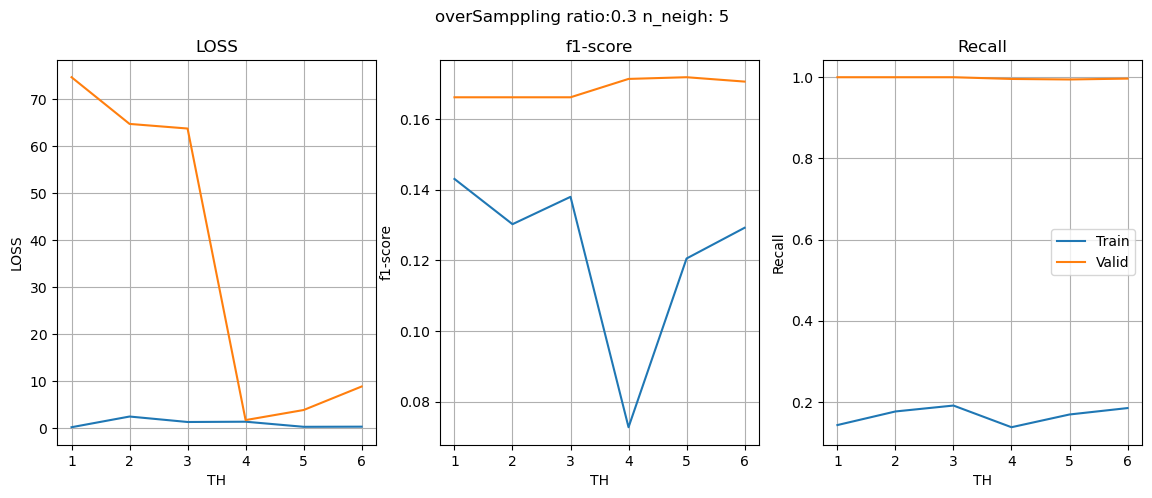

In [25]:
showLossScore(LOSS_history, Recall_history, F1score_history, resamp_ratio, n_neighbor)

##### test 데이터셋 모델 테스트

- 결과: 과대적합
<hr>
- 해결방안
	* 데이터 재샘플링: 오버샘플링, 언더샘플링
		* 오버샘플링: https://mkjjo.github.io/python/2019/01/04/smote_duplicate.html 
	* 클래스 가중치 조정: class_weight 파라미터 조정